# VAR

In [1]:
# To make realitve imports work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, FIG_DIR, STUDENT_COLOR, SALARY_COLOR
from src.dataLoading import getAllCourses, getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedBruttoSalary
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from tueplots import bundles
from tueplots.constants.color import rgb

### Load data
Load the data for all three time-series.
Values range form 2007 to 2021 (inlcuding). This is limited by the salary data.

Load enrolled students for specified courses.

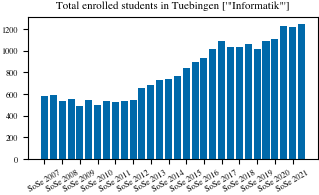

In [2]:

courses = getAllCourses() # if you use all options, dont put that in the title down marked  there
courses = ['"Informatik"']

interestingYears = YEARS[3:-4]

totalStudents = getTotalStudentsFor(courses = courses, years = interestingYears)
plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
plt.bar(interestingYears, totalStudents, color=STUDENT_COLOR)
plt.xticks(ticks=interestingYears[::2], rotation=30)
plt.title(f'Total enrolled students in Tuebingen {[course for course in courses]}') # here is there :)
plt.show()

Load inflation adjusted brutto salary data for specified sector.

Create cummulative inflation:
2.3 -> 1.023
2.8 -> 1.051644
0.2 -> 1.053747288
1.1 -> 1.065338508168
2.5 -> 1.0919719708722
2.2 -> 1.1159953542313885
1.6 -> 1.1338512798990907
0.8 -> 1.1429220901382835
0.7 -> 1.1509225447692513
0.4 -> 1.1555262349483282
1.7 -> 1.1751701809424497
1.9 -> 1.1974984143803562
1.4 -> 1.2142633921816812
0.4 -> 1.219120445750408
3.2 -> 1.258132300014421

Adjust salary for inflation:
4211.5 -> 4116.813294232649
4251.0 -> 4155.4252199413495
4302.5 -> 4091.2133763897286
4317.0 -> 4105.001312231135
4349.0 -> 4127.175509276376
4375.0 -> 4151.8493568829945
4428.0 -> 4156.425367195795
4491.5 -> 4216.030834859963
4538.0 -> 4155.784325100693
4593.0 -> 4206.151918287238
4584.0 -> 4107.54398091299
4598.0 -> 4120.0888360030385
4597.0 -> 4054.323597367301
4655.5 -> 4105.9176653346685
4805.0 -> 4204.136083692842
4854.0 -> 4247.008647293455
4927.5 -> 4281.348056300275
5012.5 -> 4355.20185331408
4930.0 -> 4266.4544091640255
4999.0 -> 4326.1674627608445
5064.0 -> 4309.163117071

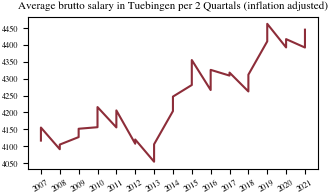

In [3]:
SECTOR = ('WZ08-62', 'Dienstleistungen der Informationstechnologie')
inflationAdjasutedBruttosalary = getInflationAdjustedBruttoSalary(SECTOR)

salaries = getSalaries()
salary_YEARS = salaries.index.levels[2]

plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
plt.plot(salary_YEARS.repeat(2), inflationAdjasutedBruttosalary, color=SALARY_COLOR)
plt.xticks(ticks=salary_YEARS, rotation=30)
plt.title('Average brutto salary in Tuebingen per 2 Quartals (inflation adjusted)')
plt.show()

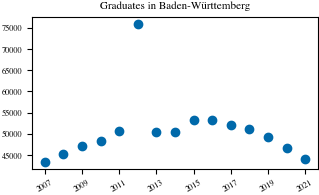

In [4]:
years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)

plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1, usetex=False))
plt.scatter(years, graduatesInBW, color=STUDENT_COLOR)
plt.xticks(ticks=years[::2], rotation=30)
plt.title('Graduates in Baden-Württemberg')
plt.show()

### Simple VAR-Modell for one subject, with data per semester

The data ranges from 2007 to (including) 2021.
Limited by the salary data.

In [5]:
PAST_STEPS = 4
PREDICTION_STPES = 10
data = np.column_stack((totalStudents, inflationAdjasutedBruttosalary, graduatesInBW.repeat(2)))

model = VAR(data)

results = model.fit(maxlags=PAST_STEPS)
# Forecasting
lagged_values = data[-PAST_STEPS:]  # Use the last available values as lagged values
forecast = results.forecast(lagged_values, steps=PREDICTION_STPES)
print(forecast)

[[ 1231.64389208  4404.48009094 47997.16485409]
 [ 1261.3566952   4472.11497737 46174.84299003]
 [ 1255.28197694  4449.47908312 44590.34635989]
 [ 1287.08996296  4499.60274075 45442.51929568]
 [ 1303.79016279  4483.44858339 47006.3441291 ]
 [ 1335.87048612  4502.816549   46923.01255376]
 [ 1356.98440726  4480.60546396 47029.72805588]
 [ 1380.89488217  4495.03702924 46858.45271752]
 [ 1395.63010929  4493.7993935  46265.28496008]
 [ 1411.86365081  4513.35635728 45405.80449313]]


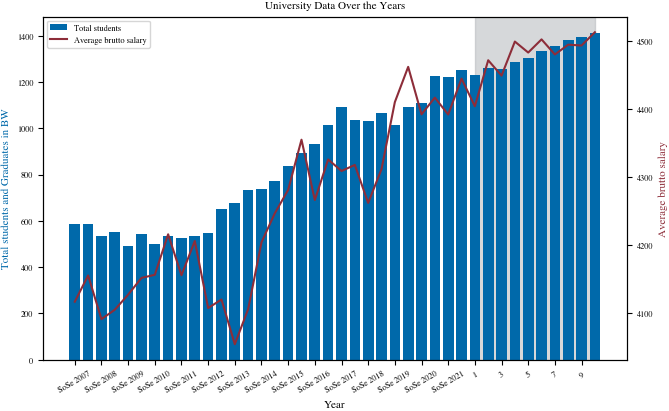

In [6]:
dataWithForecast = np.vstack((data, forecast))
yearsWithForecast = np.append(interestingYears, [f"{i+1}" for i in range(PREDICTION_STPES)])

plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=1, usetex=False))
fig, ax1 = plt.subplots()
plt.title('University Data Over the Years')
plt.xticks(rotation=30)
plt.axvspan(len(data), len(dataWithForecast) - 1, alpha=0.5, color=rgb.tue_gray)

ax1.set_xlabel('Year')
ax1.set_ylabel('Total students and Graduates in BW', color=STUDENT_COLOR)
ax1.bar(yearsWithForecast, dataWithForecast[:, 0], color=STUDENT_COLOR, label='Total students')  # Changed to bar
# ax1.tick_params(axis='y', labelcolor='tab:blue')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Average brutto salary', color=SALARY_COLOR)  # we already handled the x-label with ax1
ax2.plot(yearsWithForecast, dataWithForecast[:, 1], color=SALARY_COLOR, label='Average brutto salary')
# ax2.tick_params(axis='y', labelcolor=color)

# Create one legend for both subplots
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Get current ticks, keep only every second tick
locs, labels = plt.xticks()
plt.xticks(locs[::2], labels[::2])

plt.savefig(FIG_DIR + '/predictingStudents.pdf')
plt.show()